# Required Libraries

In [1]:
!pip install google-cloud-bigquery
!pip install --upgrade google-cloud
!pip install --upgrade google-cloud-bigquery
!pip install seaborn
!pip install plotly

     |████████████████████████████████| 215 kB 4.5 MB/s eta 0:00:01
     |████████████████████████████████| 409 kB 62.8 MB/s eta 0:00:01
     |████████████████████████████████| 4.8 MB 40.2 MB/s eta 0:00:01
     |████████████████████████████████| 120 kB 67.6 MB/s eta 0:00:01
     |████████████████████████████████| 177 kB 69.8 MB/s eta 0:00:01
     |████████████████████████████████| 223 kB 62.3 MB/s eta 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.18.0
    Uninstalling protobuf-3.18.0:
      Successfully uninstalled protobuf-3.18.0
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.32.0
    Uninstalling grpcio-1.32.0:
      Successfully uninstalled grpcio-1.32.0
  Attempting uninstall: googleapis-common-protos
    Found existing installation: googleapis-common-protos 1.53.0
    Uninstalling googleapis-common-protos-1.53.0:
      Successfully uninstalled googleapis-common-protos-1.53.0
  Attempting uninstall: google-auth
    Fo

In [2]:
from google.cloud import bigquery
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [3]:
import math
# To create nice plots
import seaborn as sns
# To count things
from collections import Counter

# To create interactive plots
import plotly.graph_objs as go
from plotly.offline import iplot
# To create plots
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap

In [4]:
# To handle datasets
from kaggle_datasets import KaggleDatasets

In [5]:
!pip install tensorflow-datasets

     |████████████████████████████████| 1.0 MB 4.4 MB/s eta 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.21.12
    Uninstalling protobuf-4.21.12:
      Successfully uninstalled protobuf-4.21.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
caip-notebooks-serverextension 1.0.0 requires google-cloud-bigquery-storage, which is not installed.
tensorflow 2.4.1 requires grpcio~=1.32.0, but you have grpcio 1.51.1 which is incompatible.
tensorboard 2.6.0 requires google-auth<2,>=1.6.3, but you have google-auth 2.16.0 which is incompatible.
matrixprofile 1.1.10 requires protobuf==3.11.2, but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.51.1 requires protobuf>=4.21.6, but you have protobuf 3.20.3 which is incompatible.
google-cloud-aiplatform 0.6.0a1 requires google-api-core[grpc]<2.0.0dev,>=1.22.2, but you hav

In [6]:
import tensorflow as tf
import tensorflow_datasets as tfds

2023-02-09 20:35:08.375842: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-02-09 20:35:08.375983: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [7]:
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.1


**Distribution Strategy;**
A TPU has eight different cores and each of these cores acts as its own accelerator. (A TPU is sort of like having eight GPUs in one machine.) We tell TensorFlow how to make use of all these cores at once through a distribution strategy.

In [8]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470


2023-02-09 20:35:13.970126: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-09 20:35:13.972946: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-02-09 20:35:13.972980: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-09 20:35:13.973011: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (3d3020fd68e2): /proc/driver/nvidia/version does not exist
2023-02-09 20:35:13.976116: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

REPLICAS:  8


In [9]:
# Allow optimization
MIXED_PRECISION = True
XLA_ACCELERATE = True

if MIXED_PRECISION:
    from tensorflow.keras.mixed_precision import experimental as mixed_precision
    if tpu: policy = tf.keras.mixed_precision.experimental.Policy('mixed_bfloat16')
    else: policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    mixed_precision.set_policy(policy)
    print('Mixed precision enabled')

if XLA_ACCELERATE:
    tf.config.optimizer.set_jit(True)
    print('Accelerated Linear Algebra enabled')

Mixed precision enabled
Accelerated Linear Algebra enabled


Parameter Define

In [10]:
# Set batch size
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
# Set number of epochs
EPOCHS = 50
# Patience for the learning rate
LR_PATIENCE = 5

# Patience for early stopping
STOPPING_PATIENCE = 30

# Serialized array shape
SHAPE = (600, 800, 4)
# Number of classes
NUM_CLASSES = 13

In [11]:
!ls
#Set number of images in buffer
BUFFER_SIZE = 1024 
# Set paths to the data
PATH_DATA = 'semantic-segmentation-with-carla-and-tpus'
# Allow self optimization
AUTO = tf.data.experimental.AUTOTUNE

__notebook_source__.ipynb


In [12]:
# Label of the classes
CLASSES = {0:'Unlabeled',
           1:'Building',
           2:'Fence',
           3:'Other',
           
           4:'People',
           5:'Posts',
           6:'Road Marking',
           7:'Street',
           8:'Sidewalk',
           
           9:'Vegatation',
           10:'Vehicle',
           11:'Wall',
           12:'Traffic Sign'}

In [13]:
# RGB colors of the classes
COLORS = [(80/255, 168/255, 250/255),
          (242/255, 130/255, 30/255),
          
          (50/255, 50/255, 50/255),
          (27/255, 44/255, 129/255),
          
          (163/255, 68/255, 222/255),
          (115/255, 0/255, 0/255),
          
          (255/255, 255/255, 255/255),
          (191/255, 191/255, 191/255),
          
          (150/255, 150/255, 150/255),
          (22/255, 146/255, 0/255),
          
          (245/255, 239/255, 46/255),
          
          (181/255, 103/255, 10/255),
          (235/255, 0/255, 0/255)]

In [14]:
def loadDataset(filenames):
    # Disable order to increase speed
    options = tf.data.Options()
    options.experimental_deterministic = False
    
    # Define a TFRecords dataset with all filenames
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    # Add options for the order to the dataset
    dataset = dataset.with_options(options)
    # Return a dataset
    dataset = dataset.map(readTFRecord, num_parallel_calls=AUTO)
    return dataset

In [15]:
def readTFRecord(example):
    # Parse the serialized example
    example = tf.io.parse_single_example(example, exampleStructure)
    return example['raw_image']

# Define structure of examples
exampleStructure = {'raw_image': tf.io.FixedLenFeature([np.prod(SHAPE)], tf.int64)}

# Set the path to all data files
gcs_path = KaggleDatasets().get_gcs_path(PATH_DATA)

In [16]:
# Get a list of all files from the training folder
train_files = tf.io.gfile.glob(gcs_path + '/data_train/data_train/*.tfrecords')

# Get a list of all files from the testing folder
test_files = tf.io.gfile.glob(gcs_path + '/data_test/data_test/*.tfrecords')

2023-02-09 20:35:21.254498: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2023-02-09 20:35:21.337779: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


In [17]:
# Create datasets from file names
train_dataset = loadDataset(train_files)
test_dataset = loadDataset(test_files)

Class label distribuation

In [18]:
def countLabels(dataset):
    # Counter for the labels
    label_counter = Counter()
    
    # Number of images
    n_images = 0

    # Iterate over the whole dataset
    for image_tensor in dataset:
        
        # Count images
        n_images += 1

        # Get the label channel
        flat_mask = tf.reshape(image_tensor, SHAPE)[:,:,3].numpy()

        # Count the labels
        x = np.bincount(flat_mask.flatten())
        y = np.nonzero(x)[0]

        # Update the counter
        for key, val in zip(y,x[y]):
            label_counter[key] += val
            
    # Return counted labels and number of images
    return label_counter, n_images


# Count labels in train- and test-dataset
train_label_counts, n_train_images = countLabels(train_dataset)
test_label_counts, n_test_images = countLabels(test_dataset)


# Create dataframe for the counted train labels
df_train_label_counts = pd.DataFrame.from_dict(train_label_counts, orient='index').rename({0:'Train'}, axis=1)
df_train_label_counts.index = [CLASSES[i] for i in df_train_label_counts.index]

# Create dataframe for the counted test labels
df_test_label_counts = pd.DataFrame.from_dict(test_label_counts, orient='index').rename({0:'Test'}, axis=1)
df_test_label_counts.index = [CLASSES[i] for i in df_test_label_counts.index]


# Combine the label counts dataframes
df_label_counts = df_train_label_counts.join(df_test_label_counts)
df_label_counts = df_label_counts.stack().to_frame().reset_index().rename({'level_0':'Label', 'level_1':'Dataset', 0:'Count'}, axis=1)


##### Create Label Count Plot #####

df_tmp_train = df_label_counts[df_label_counts['Dataset']=='Train'].sort_values('Count', ascending=False)
df_tmp_test = df_label_counts[df_label_counts['Dataset']=='Test'].sort_values('Count', ascending=False)


# Set up the data
trace1 = go.Bar(y = df_tmp_train['Label'],
                x = df_tmp_train['Count'],
                base = 0,
                name = 'Train',
                textposition = 'auto',
                hovertemplate = 'Pixel:  %{x}<br>Label: %{y}',
                width = 0.4,
                marker = dict(color = '#cc3600'),
                orientation='h',
                opacity = 1.0)

trace2 = go.Bar(y = df_tmp_test['Label'],
                x = df_tmp_test['Count'],
                base = 0,
                name = 'Test',
                textposition = 'auto',
                hovertemplate = 'Pixel:  %{x}<br>Label: %{y}',
                width = 0.4,
                marker = dict(color = '#cc9c00'),
                orientation='h',
                opacity = 1.0)

# Set up the layout
layout = dict(title = 'How Many Pixels Are There Per Label?',
              xaxis = dict(title = 'Count On Logscale',
                           type='log'),
              yaxis = dict(title = 'Label'),
              font = dict(family = 'sans-serif',
                          size = 18,
                          color = '#2f2f2f'),
              plot_bgcolor = '#dddddd')

# Create the plot
fig = go.Figure(data=[trace1, trace2], layout=layout)
iplot(fig)

2023-02-09 20:36:21.234975: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 36424, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1675974981.231677055","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 36424, Output num: 0","grpc_status":3}


 represent the raw training dataset

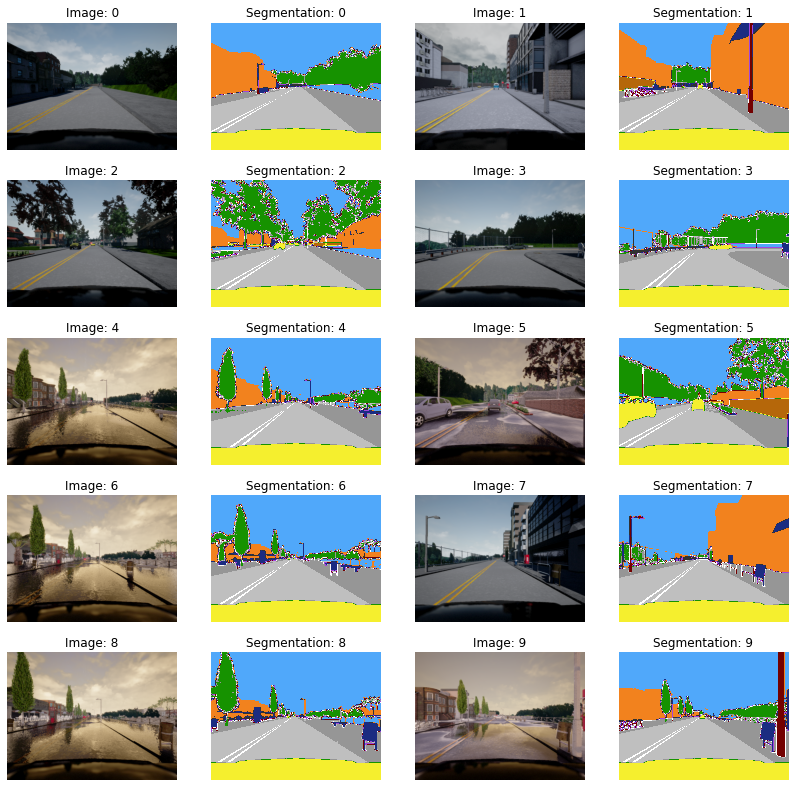

In [19]:
# Create a colormap for the labels
cm = LinearSegmentedColormap.from_list('semantic_map', 
                                       COLORS, 
                                       N=NUM_CLASSES)

# Normalize the labels
norm = Normalize(vmin=0, vmax=12)

# Setup subplots
rows, cols = 5, 4

# Create iterator for dataset tensors
tensor_iterator = iter(train_dataset)

# Create the subplots
fig, arr = plt.subplots(rows, cols, figsize=(14, 14))

# Iterate over the first images
for i in range(int(rows*cols/2)):
    
    # Get the next data tensor
    image_tensor = next(tensor_iterator)
    
    # Get the image and mask channels
    flat_image = tf.reshape(image_tensor, SHAPE)[:,:,:3].numpy()
    flat_mask = tf.reshape(image_tensor, SHAPE)[:,:,3].numpy()
    
    # Reshape the image and mask 
    image = flat_image.reshape((SHAPE[0], SHAPE[1], 3))
    mask = flat_mask.reshape((SHAPE[0], SHAPE[1]))
    
    
    # Populate the subplots
    arr[i//2][i*2%cols].imshow(image)
    arr[i//2][i*2%cols].set_title('Image: {}'.format(i))
    arr[i//2][i*2%cols].axis('off')
    arr[i//2][i*2%cols+1].imshow(mask, cmap=cm, norm=norm)
    arr[i//2][i*2%cols+1].set_title('Segmentation: {}'.format(i))
    arr[i//2][i*2%cols+1].axis('off')
plt.show()

represent the Augmented training dataset

In [20]:
def trainingDataset(dataset, augmentation=True):
    # Reshape image tensor
    dataset = dataset.map(reshapeImage, num_parallel_calls=AUTO)
    
    # Perform augmentation
    if augmentation:
        # Random horizontal flip
        dataset = dataset.map(tf.image.random_flip_left_right, num_parallel_calls=AUTO)
        # Random rotation, shear, zoom and shift
        dataset = dataset.map(transformImage, num_parallel_calls=AUTO)
    
    # Split image and mask
    dataset = dataset.map(splitImage, num_parallel_calls=AUTO)
    
    # Repeat the dataset 
    dataset = dataset.repeat()
    # Set a buffersize to randomly choose images from
    dataset = dataset.shuffle(BUFFER_SIZE)
    # Set batchsize
    dataset = dataset.batch(BATCH_SIZE)
    # Prepare the next batch while training
    dataset = dataset.prefetch(AUTO)
    return dataset



def reshapeImage(tensor):
    # Reshape serialized data to tensor
    return tf.reshape(tensor, SHAPE)



def splitImage(tensor):
    # Slice image from tensor
    image = tensor[:,:,:3]
    # Slice mask from tensor
    mask = tensor[:,:,3]
    
    # Cast and normalize the ints to floats in [0, 1] range
    image = tf.cast(image, tf.float32) / 255.0
    return image, mask



def transformImage(tensor):
    # Get dimensions of image
    dim_x, dim_y, dim_z = SHAPE
    
    # Get random values for the transformation
    rot = 15. * tf.random.normal([1],dtype='float32')
    shr = 15. * tf.random.normal([1],dtype='float32')
    h_zoom = 1. + tf.random.normal([1],dtype='float32')/5.
    w_zoom = 1.33 + tf.random.normal([1],dtype='float32')/5.
    h_shift = 50. * tf.random.normal([1],dtype='float32')
    w_shift = 100. * tf.random.normal([1],dtype='float32')
  
    # Get transformation matrix from random transformation values
    m = transformationMatrix(rot, shr, h_zoom, w_zoom, h_shift, w_shift) 

    # Get a list of destination pixel indices
    x = tf.repeat( tf.range(dim_x//2, -dim_x//2, -1), dim_y )
    y = tf.tile( tf.range(-dim_y//2,dim_y//2), [dim_x] )
    z = tf.ones([dim_x*dim_y], dtype='int32')
    idx = tf.stack( [x, y, z] )
    
    # Rotate the destination pixels onto the origin pixels
    idx2 = K.dot(m, tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -dim_x//2+1, dim_x//2)
    
    # Find origin pixel values
    idx3 = tf.stack( [dim_x//2-idx2[0,], dim_x//2-1+idx2[1,]] )
    d = tf.gather_nd(tensor, tf.transpose(idx3))
    
    # Return transformed image
    return tf.reshape(d, SHAPE)



def transformationMatrix(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    ##### Create a single 3x3 transformation matrix from 4 individual transformations #####
        
    # Convert degrees to radians
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.
    
    # Rotation matrix
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )
        
    # Shear matrix
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    
    
    # Zoom matrix
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )
    
    # Shift matrix
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )
    
    # Combine all four transformation matrices into a single transformation matrix
    return K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))



def testingDataset(dataset):
    # Reshape image tensor
    dataset = dataset.map(reshapeImage, num_parallel_calls=AUTO)
    
    # Split image and mask
    dataset = dataset.map(splitImage, num_parallel_calls=AUTO)
    
    # Set batchsize
    dataset = dataset.batch(BATCH_SIZE)
    # Prepare the next batch while training
    dataset = dataset.prefetch(AUTO)
    return dataset

In [21]:
import tensorflow.keras.backend as K

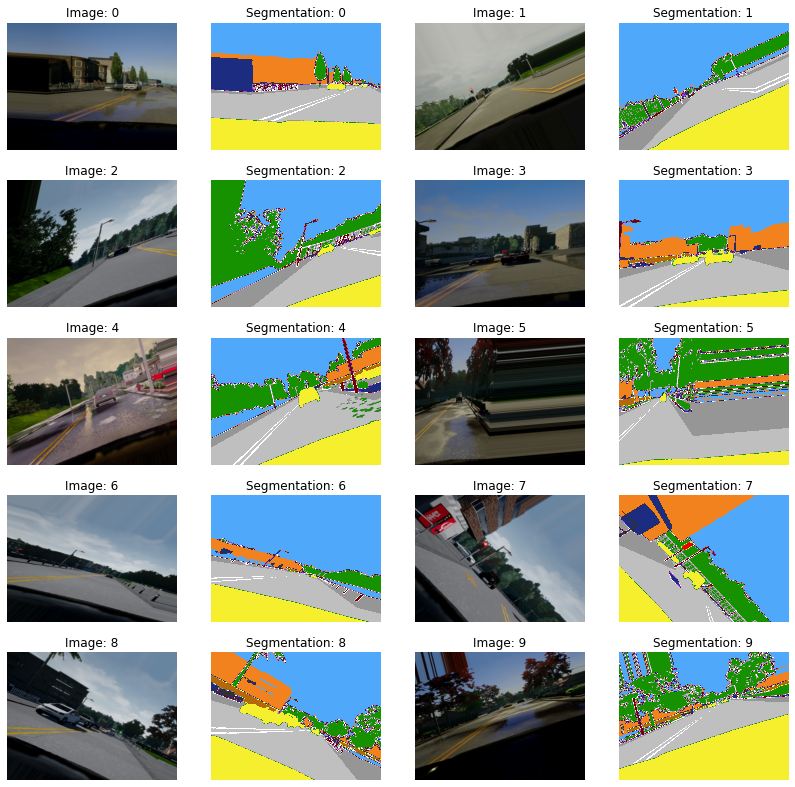

In [22]:
# Get the training dataset
train_dataset = trainingDataset(train_dataset, augmentation=True)

# Create iterator for dataset tensors
train_dataset_iterator = iter(train_dataset.unbatch())

# Create the subplots
fig, arr = plt.subplots(5, 4, figsize=(14, 14))

# Iterate over the first images
for i in range(10):
    
    # Get the next image and mask
    image, mask = next(train_dataset_iterator)
    
    
    # Populate the subplots
    arr[i//2][i*2%4].imshow(image)
    arr[i//2][i*2%4].set_title('Image: {}'.format(i))
    arr[i//2][i*2%4].axis('off')
    arr[i//2][i*2%4+1].imshow(mask, cmap=cm, norm=norm)
    arr[i//2][i*2%4+1].set_title('Segmentation: {}'.format(i))
    arr[i//2][i*2%4+1].axis('off')
plt.show()

# ***Auto Encoder Decoder Model; U-Net***

In [23]:
!pip install keras

     |████████████████████████████████| 1.7 MB 3.9 MB/s eta 0:00:01


In [24]:
# To create a model
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, Conv2DTranspose

In [25]:
def getModel():
    
    # Use the TPU strategy
    with strategy.scope():
        
        # Build the model
        input_img = Input((SHAPE[0], SHAPE[1], 3), name='img')

        ##### Convolutions #####
        c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (input_img)
        p1 = MaxPooling2D((2, 2)) (c1)

        c2 = Conv2D(12, (3, 3), activation='relu', padding='same') (p1)
        p2 = MaxPooling2D((2, 2)) (c2)

        c3 = Conv2D(16, (3, 3), activation='relu', padding='same') (p2)
        p3 = MaxPooling2D((2, 2)) (c3)
        
        c4 = Conv2D(24, (3, 3), activation='relu', padding='same') (p3)
        p4 = MaxPooling2D((5, 5)) (c4)

        
        c5 = Conv2D(36, (3, 3), activation='relu', padding='same') (p4)

        ##### Deconvolutions #####
        u6 = Conv2DTranspose(24, (2, 2), strides=(5, 5), padding='same') (c5)
        u6 = concatenate([u6, c4])
        c6 = Conv2D(20, (3, 3), activation='relu', padding='same') (u6)

        
        u7 = Conv2DTranspose(20, (2, 2), strides=(2, 2), padding='same') (c6)
        u7 = concatenate([u7, c3])
        c7 = Conv2D(18, (3, 3), activation='relu', padding='same') (u7)

        u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
        u8 = concatenate([u8, c2])
        c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)

        u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
        u9 = concatenate([u9, c1])
        c9 = Conv2D(16, (3, 3), activation='relu', padding='same') (u9)

        outputs = Conv2D(13, (1, 1), activation='softmax') (c9)
        model = Model(inputs=[input_img], 
                      outputs=[outputs])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])

    print(model.summary())
    
    return model

In [26]:
model = getModel()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 600, 800, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 600, 800, 8)  224         img[0][0]                        
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 300, 400, 8)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 300, 400, 12) 876         max_pooling2d[0][0]              
______________________________________________________________________________________________

 U-NET Model Training Process on TPU;

In [27]:
# Get the train- and test-dataset
train_dataset = trainingDataset(loadDataset(train_files), augmentation=True)
test_dataset = testingDataset(loadDataset(test_files))


# Setup callbacks
learning_rate = ReduceLROnPlateau(patience=LR_PATIENCE, verbose=1, factor=0.5, min_delta=0.00001)
early_stopping = EarlyStopping(patience=STOPPING_PATIENCE, verbose=1)

In [ ]:
history = model.fit(train_dataset, 
                    steps_per_epoch = int(n_train_images / BATCH_SIZE),
                    epochs = EPOCHS,
                    
                    callbacks = [early_stopping, learning_rate],
                    
                    validation_data = test_dataset,
                    validation_steps = int(n_test_images / BATCH_SIZE))

Epoch 1/50
35/35 [==============================] - 137s 3s/step - loss: 2.4280 - sparse_categorical_accuracy: 0.2204 - val_loss: 1.7734 - val_sparse_categorical_accuracy: 0.4647
Epoch 2/50
35/35 [==============================] - 81s 2s/step - loss: 1.6215 - sparse_categorical_accuracy: 0.5040 - val_loss: 1.4574 - val_sparse_categorical_accuracy: 0.5501
Epoch 3/50
35/35 [==============================] - 78s 2s/step - loss: 1.2287 - sparse_categorical_accuracy: 0.6227 - val_loss: 1.2839 - val_sparse_categorical_accuracy: 0.6105
Epoch 4/50
35/35 [==============================] - 81s 2s/step - loss: 1.1006 - sparse_categorical_accuracy: 0.6687 - val_loss: 1.0635 - val_sparse_categorical_accuracy: 0.6948
Epoch 5/50
35/35 [==============================] - 81s 2s/step - loss: 0.9231 - sparse_categorical_accuracy: 0.7235 - val_loss: 0.9852 - val_sparse_categorical_accuracy: 0.7262
Epoch 6/50
35/35 [==============================] - 78s 2s/step - loss: 0.8242 - sparse_categorical_accuracy:

**How Did The Training Process Go?**

In [ ]:
# Get the training results
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

lr = history.history['lr']

In [ ]:
##### Plot Training And Validation Accuracy ######

# Create template for hovertool
hovertemplate = 'Sparse Accuracy: %{y:.3f}<br>Epoch: %{x}'

# Set up the data
trace1 = go.Scatter(x = list(range(1, len(acc)+1)), 
                    y = acc, 
                    name = 'Training',
                    marker = dict(color = '#cc3600'),
                    hovertemplate = hovertemplate)

trace2 = go.Scatter(x = list(range(1, len(acc)+1)), 
                    y = val_acc, 
                    name = 'Testing',
                    marker = dict(color = '#0033cc'),
                    hovertemplate = hovertemplate)

# Set up the layout
layout = go.Layout(title = 'Sparse Accuracy During The Training',
                   font = dict(family = 'sans-serif',
                               size = 14,
                               color = '#2f2f2f'),
                   xaxis = dict(title = 'Epoch'),
                   yaxis = dict(title = 'Accuracy',
                                type='log'),
                   plot_bgcolor = '#ffdacc',
                   hovermode='x')

# Create the plot
fig = go.Figure(data=[trace1, trace2], layout=layout)
iplot(fig)


In [ ]:
##### Plot Training And Validation Loss ######

# Create template for hovertool
hovertemplate = 'Loss:   %{y:.3f}<br>Epoch: %{x}'

# Set up the data
trace1 = go.Scatter(x = list(range(1, len(loss)+1)), 
                    y = loss, 
                    name = 'Training',
                    marker = dict(color = '#cc3600'),
                    hovertemplate = hovertemplate)

trace2 = go.Scatter(x = list(range(1, len(loss)+1)), 
                    y = val_loss, 
                    name = 'Testing',
                    marker = dict(color = '#0033cc'),
                    hovertemplate = hovertemplate)

# Set up the layout
layout = go.Layout(title = 'Loss During The Training',
                   font = dict(family = 'sans-serif',
                               size = 14,
                               color = '#2f2f2f'),
                   xaxis = dict(title = 'Epoch'),
                   yaxis = dict(title = 'Loss',
                                type='log'),
                   plot_bgcolor = '#ffdacc',
                   hovermode='x')

# Create the plot
fig = go.Figure(data=[trace1, trace2], layout=layout)
iplot(fig)



##### Plot Learning Rate ######

# Create template for hovertool
hovertemplate = 'Learning Rate:  %{y:.3f}<br>Epoch: %{x}'

# Set up the data
trace1 = go.Scatter(x = list(range(1, len(lr)+1)), 
                    y = lr, 
                    name = 'Training',
                    marker = dict(color = '#cc3600'),
                    hovertemplate = hovertemplate)

# Set up the layout
layout = go.Layout(title = 'Learning Rate During The Training',
                   font = dict(family = 'sans-serif',
                               size = 14,
                               color = '#2f2f2f'),
                   xaxis = dict(title = 'Epoch'),
                   yaxis = dict(title = 'Learning Rate',
                                type='log'),
                   plot_bgcolor = '#ffdacc',
                   hovermode='x')

# Create the plot
fig = go.Figure(data=[trace1], layout=layout)
iplot(fig)

**Comparing some test images and creating the confusion matrix can show which labels pose a challenge.**

In [ ]:
# Create iterator for dataset tensors
test_dataset_iterator = iter(test_dataset.unbatch())

# Create the subplots
fig, arr = plt.subplots(5, 3, figsize=(14, 18))

# Iterate over the first images
for i in range(5):
    
    # Get the next image and mask
    image, mask = next(test_dataset_iterator)
    
    prediction_r = model.predict(np.expand_dims(image.numpy(), axis=0))[0]
    prediction = tf.argmax(prediction_r, axis=2)
    
    
    # Populate the subplots
    arr[i][0].imshow(image)
    arr[i][0].set_title('Image: {}'.format(i))
    arr[i][0].axis('off')
    arr[i][1].imshow(mask, cmap=cm, norm=norm)
    arr[i][1].set_title('Segmentation: {}'.format(i))
    arr[i][1].axis('off')
    arr[i][2].imshow(prediction, cmap=cm, norm=norm)
    arr[i][2].set_title('Prediction: {}'.format(i))
    arr[i][2].axis('off')
plt.show()

In [ ]:
# Get counter for all pixel-predictions
counter = Counter()

# Iterate over the whole test dataset
for images, masks in test_dataset:
    
    # Get a prediction for the images
    predictions_r = model.predict(images)
    # Get the pixel labels
    predictions = tf.argmax(predictions_r, axis=3)
    
    # Add the preditions to the counter
    counter.update(zip(masks.numpy().flatten(), predictions.numpy().flatten()))


# Extract data from counter
counter_data = [[i, j, value] for (i, j), value in counter.items()]

# Create dataframe from counter
df_counter = pd.DataFrame(counter_data, columns=['Truth', 'Prediction', 'Count'])

# Pivot dataframe to get confusion matrix
piv = pd.pivot_table(df_counter, index='Truth', columns='Prediction', values='Count').fillna(0)

# Add missing columns
for i in piv.index:
    if i not in piv.columns:
        piv[i] = 0

# Sort columns
piv = piv[piv.index]

# Rename the columns and indices
piv = piv.rename(CLASSES, axis=0)
piv = piv.rename(CLASSES, axis=1)


# Count correct pixel
num_correct_pixel = np.diag(piv).sum()

# Count all pixel
num_all_pixel = piv.sum().sum()

# Compute overall accuracy
accuracy = num_correct_pixel / num_all_pixel


# Normalize the dataframe
piv = piv.divide(piv.sum(axis=1), axis=0).round(3)


# Create a plot for the confusion matrix
plt.figure(figsize = (12, 12))
plt.title('Confusion Matrix With Overall Accuracy: {:.3f}'.format(accuracy))
sns.heatmap(piv, annot=True, cmap='binary')
plt.show()

Deploment Practice Example;https://deepchecks.com/best-practices-for-computer-vision-model-deployment/